In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
from yaml import Loader
import numpy as np
import analyze_cells_energy as ace
import utils
from scipy.stats import ttest_ind, mannwhitneyu
import scipy.stats

# Analysis Dati PISA Pizzorusso LAB

In [2]:
root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'PISA'
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'

In [3]:
# load query file where we added volumes for each area
volumes = ace.clean_volumes_database()

In [4]:
def load_subject(subject, data_directory):
    file_suffix = 'cells'
    df_mouse = pd.read_csv(data_directory + subject + '/' + file_suffix + '.csv')
    df_mouse = ace.reformat_df_mouse(df=df_mouse)
    return df_mouse

In [5]:
def find_significant_areas(dictionary, experimental_groups, value, test='mannwhitneyu', alpha=0.05):
    """
    Identify significant areas based on statistical testing across experimental groups.

    This function performs a non-parametric statistical test (e.g., Mann-Whitney U) 
    across experimental groups to identify areas that show significant differences
    for a specified value (e.g., 'n_cells'). It returns a DataFrame containing the 
    areas with significant p-values.

    Parameters:
    dictionary (dict): Dictionary containing data for multiple mice.
    experimental_groups (dict): Dictionary defining the experimental groups.
    value (str): The key in the dictionary whose values will be compared across groups.
    test (str): The statistical test to use (default is 'mannwhitneyu').
    alpha (float): The significance level for the test (default is 0.05).

    Returns:
    pd.DataFrame: A DataFrame containing significant areas with their p-values.
    """
    
    # Calculate the specified value across experimental groups
    dfs = ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                                            dict_results_across_mice=dictionary, 
                                            value=value)
    
    # Perform statistical tests across the groups
    df_ttest = ace.test_across_groups(dfs, test=test, groups=list(experimental_groups.keys()))

    # Extract the column names corresponding to p-values
    columns = df_ttest.loc[:, df_ttest.columns != 'area'].columns

    # Initialize an empty DataFrame to store significant areas
    df_sigareas = pd.DataFrame()

    # Iterate through each p-value column to identify significant areas
    for col in columns:
        # Sort the DataFrame by the p-value column and select the areas with significant p-values
        df = df_ttest.sort_values(by=col)[['area', col]]
        df_sigareas = pd.concat([df_sigareas, df[df[col] < alpha]['area'].reset_index(drop=True)], axis=1)
    
    # Rename the columns to remove 'pval_' prefix
    df_sigareas.columns = [col.replace('pval_', '') for col in columns]

    return df_sigareas

In [6]:
# #NB: Run only if file does not exist or needs to be regenerated
# dict_results_across_mice = {subject: ace.calculate_cells_energy_per_level(df_mouse=load_subject(subject=subject,
#                                                                                                data_directory=data_directory), 
#                                                                           vol=volumes, 
#                                                                           level=8,
#                                       macroareas_to_remove=['Medulla', 'Cerebellar cortex', 'Cerebellar nuclei']) for subject in subjects}
# np.save('dict_results/newvolumes/dict_results_across_mice_PISA_with_Pons.npy', dict_results_across_mice)

In [6]:
dict_results_across_mice = np.load('dict_results/newvolumes/dict_results_across_mice_PISA_with_Pons.npy', 
                                   allow_pickle=True).item()
# reformat dictionary and subjects
old_keys = list(dict_results_across_mice.keys())
for key in old_keys:
    group = key.split('_')[-1] if key.split('_')[-1][-1]!='2' else key.split('_')[-1][:-1]
    number = key.split('_')[0]
    new_key = 'BL'+number+group
    dict_results_across_mice[new_key] = dict_results_across_mice[key]
    del dict_results_across_mice[key]
    
#remove BL12_noshock due to biased number of cells
del dict_results_across_mice['BL12noshock']

subjects = list(dict_results_across_mice.keys())

In [8]:
# saving data
for subject in subjects:
    dict_results_across_mice[subject].to_csv(data_directory+subject+'.csv', 
                                       index=False)

In [7]:
experimental_groups = utils.divide_in_exp_groups(list_subjects=subjects,
                                                group_labels=['noshock','demonstrator', 'observer'])

In [8]:
df_noshock_ncells, df_demonstrator_ncells, df_observer_ncells = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='n_cells')

In [11]:
df_noshock_ncells.set_index('area').sum()

BL13noshock    438740
BL1noshock     174545
BL20noshock     91596
BL19noshock    174584
BL15noshock     55871
BL11noshock    134309
BL7noshock     198913
dtype: int64

In [12]:
df_demonstrator_ncells.set_index('area').sum()

BL4demonstrator     619276
BL9demonstrator     141886
BL17demonstrator    207513
BL22demonstrator     87029
BL6demonstrator     260235
BL14demonstrator    535948
BL3demonstrator     485684
dtype: int64

In [13]:
df_observer_ncells.set_index('area').sum()

BL2observer     602260
BL16observer    419430
BL10observer    295400
BL5observer     428346
BL18observer    269764
BL8observer     358726
BL21observer    176593
dtype: int64

# Calculate t-tests number of cell across groups per area

In [9]:
df_noshock_ncells, df_demonstrator_ncells, df_observer_ncells = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='n_cells')
df_ttest_ncells = ace.test_across_groups([df_noshock_ncells,
                                          df_demonstrator_ncells,
                                          df_observer_ncells],
                                        groups=['noshock',
                                               'demonstrator',
                                               'observer'],
                                        test='mannwhitneyu')

In [15]:
df_demonstrator_ncells.set_index('area').loc['Locus ceruleus']

BL4demonstrator     93
BL9demonstrator     13
BL17demonstrator    19
BL22demonstrator     0
BL6demonstrator     68
BL14demonstrator     4
BL3demonstrator     60
Name: Locus ceruleus, dtype: int64

In [71]:
find_significant_areas(dictionary=dict_results_across_mice, 
                       experimental_groups=experimental_groups,
                       value='density',
                       test='mannwhitneyu',
                      alpha=0.01).to_csv('significant_areas_density.csv')

In [72]:
find_significant_areas(dictionary=dict_results_across_mice, 
                       experimental_groups=experimental_groups,
                       value='energy',
                       test='mannwhitneyu',
                      alpha=0.01).to_csv('significant_areas_energy.csv')

In [18]:
find_significant_areas(dictionary=dict_results_across_mice, 
                       experimental_groups=experimental_groups,
                       value='relative_density',
                       test='mannwhitneyu',
                      alpha=0.05)

,noshock_vs_demonstrator,noshock_vs_observer,demonstrator_vs_observer
0,Intercollicular nucleus,Anterior hypothalamic area,Substantia nigra lateral part
1,Suprachiasmatic preoptic nucleus,Lateral tegmental nucleus,Lateral tegmental nucleus
2,Lateral strip of striatum,Nucleus circularis,Lateral strip of striatum
3,Retroethmoid nucleus,Retroethmoid nucleus,Pontine reticular nucleus ventral part
4,Anterior hypothalamic area,Lateral strip of striatum,Suprachiasmatic preoptic nucleus
5,Nucleus circularis,Pontine reticular nucleus ventral part,Anterior hypothalamic area
6,Pineal body,Superior salivatory nucleus,Nucleus circularis
7,Lateral tegmental nucleus,Substantia nigra lateral part,Pineal body
8,Cortical amygdalar area,Intercollicular nucleus,Superior salivatory nucleus
9,Substantia nigra lateral part,Suprachiasmatic preoptic nucleus,Intercollicular nucleus


In [19]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_ncells = df_ttest_ncells.dropna(axis=0,
                                   how='all')

In [20]:
#sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_noshock_vs_demonstrator')[['area', 'pval_noshock_vs_demonstrator']][0:20].set_index('area')

,pval_noshock_vs_demonstrator
area,
Taenia tecta,0.00246895
Piriform area,0.00246895
Cortical amygdalar area,0.00246895
Posterolateral visual area,0.00361311
Anterior olfactory nucleus,0.00364518
Piriform-amygdalar area,0.00530167
Claustrum,0.00530167
Anteromedial visual area,0.0075968
Basomedial amygdalar nucleus,0.0075968


In [21]:
#sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_noshock_vs_observer')[['area', 'pval_noshock_vs_observer']][0:30].set_index('area')

,pval_noshock_vs_observer
area,
Posterolateral visual area,0.00107035
Parataenial nucleus,0.00108251
Dorsomedial nucleus of the hypothalamus,0.00108251
Retrosplenial area,0.00164726
Anterior olfactory nucleus,0.00164726
Taenia tecta,0.00164726
Supragenual nucleus,0.0024218
Claustrum,0.00246895
Cortical amygdalar area,0.00246895


In [22]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_demonstrator_vs_observer')[['area', 'pval_demonstrator_vs_observer']][0:10].set_index('area')

,pval_demonstrator_vs_observer
area,
Preparasubthalamic nucleus,0.0483488
Pedunculopontine nucleus,0.0626005
Lateral habenula,0.0626005
Globus pallidus internal segment,0.0626005
Midbrain reticular nucleus retrorubral area,0.0799321
Pontine reticular nucleus caudal part,0.0799321
Ventral tegmental area,0.0799321
Laterodorsal tegmental nucleus,0.0799321
Perireunensis nucleus,0.100172


# Correlations across number of cells

In [10]:
corr_matrix_noshock_ncells = ace.cross_corr(df_noshock_ncells)
corr_matrix_demonstrator_ncells = ace.cross_corr(df_demonstrator_ncells)
corr_matrix_observer_ncells = ace.cross_corr(df_observer_ncells)

In [11]:
corr_matrix_noshock_ncells

area,Frontal pole cerebral cortex,Primary motor area,Secondary motor area,Primary somatosensory area,Supplemental somatosensory area,Visceral area,Dorsal auditory area,Primary auditory area,Posterior auditory area,Ventral auditory area,...,Tegmental reticular nucleus,Motor nucleus of trigeminal,Superior central nucleus raphe,Locus ceruleus,Laterodorsal tegmental nucleus,Nucleus incertus,Pontine reticular nucleus,Nucleus raphe pontis,Subceruleus nucleus,Sublaterodorsal nucleus
area,,,,,,,,,,,,,,,,,,,,,
Frontal pole cerebral cortex,1.000000,0.857683,0.863977,0.817236,0.804601,0.092413,0.804448,0.682956,0.718032,0.632952,...,0.390645,0.784964,-0.225931,0.214062,0.416390,0.223511,0.508510,-0.286247,0.707014,0.437895
Primary motor area,0.857683,1.000000,0.959334,0.993098,0.972685,0.217466,0.940962,0.880515,0.879777,0.726359,...,0.584990,0.945869,-0.020996,0.116492,0.146893,0.412148,0.734963,-0.091684,0.664600,0.271263
Secondary motor area,0.863977,0.959334,1.000000,0.940458,0.949960,0.422099,0.983494,0.862815,0.919496,0.866210,...,0.478154,0.852748,-0.087546,0.288387,0.282304,0.420018,0.657903,-0.102992,0.612212,0.376727
Primary somatosensory area,0.817236,0.993098,0.940458,1.000000,0.982138,0.199614,0.939322,0.912011,0.896732,0.727944,...,0.652846,0.963794,0.061104,0.014602,0.145358,0.466645,0.790997,-0.020125,0.708787,0.287582
Supplemental somatosensory area,0.804601,0.972685,0.949960,0.982138,1.000000,0.265611,0.968247,0.960212,0.955104,0.782040,...,0.699026,0.955673,0.138876,0.024052,0.143302,0.565132,0.810909,0.071172,0.730553,0.384294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Nucleus incertus,0.223511,0.412148,0.420018,0.466645,0.565132,0.453906,0.562696,0.765098,0.716807,0.554332,...,0.870967,0.445573,0.848188,-0.314025,-0.095472,1.000000,0.854158,0.851413,0.555850,0.738081
Pontine reticular nucleus,0.508510,0.734963,0.657903,0.790997,0.810909,0.247896,0.754640,0.913804,0.834877,0.620741,...,0.947988,0.774890,0.639996,-0.399531,0.030496,0.854158,1.000000,0.565613,0.779247,0.584226
Nucleus raphe pontis,-0.286247,-0.091684,-0.102992,-0.020125,0.071172,0.329135,0.063046,0.337301,0.258683,0.139491,...,0.654952,-0.020334,0.973143,-0.475152,-0.280245,0.851413,0.565613,1.000000,0.206002,0.555529


Text(0.5, 1.0, 'OBSERVER')

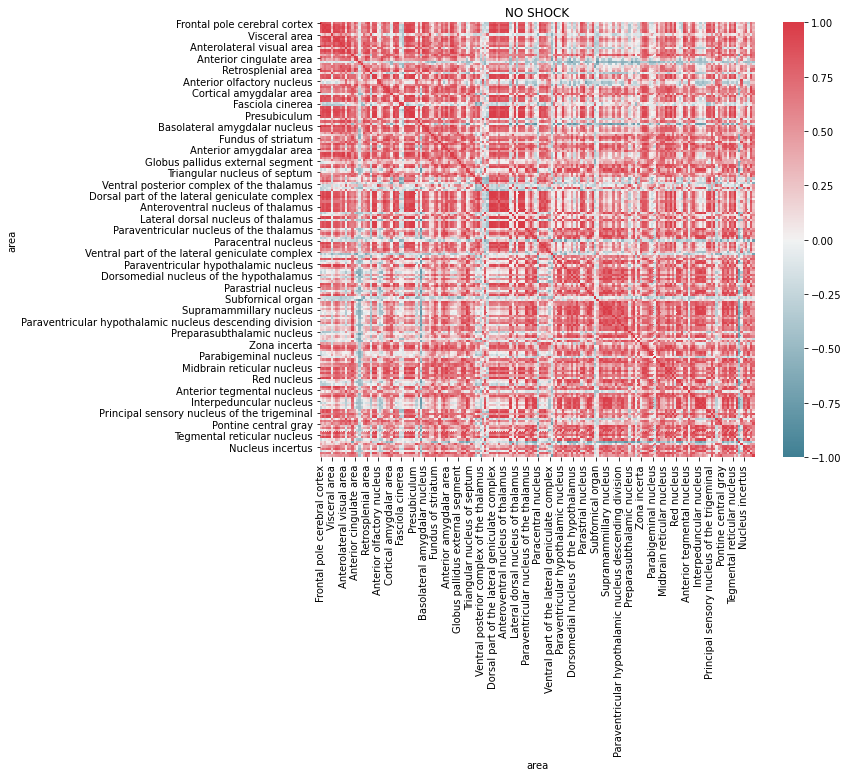

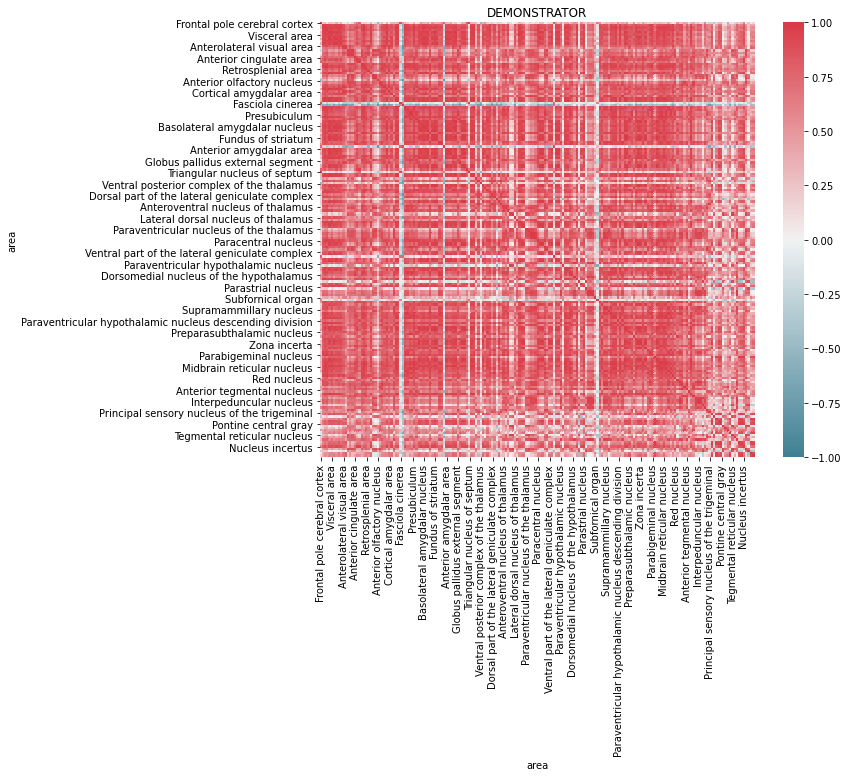

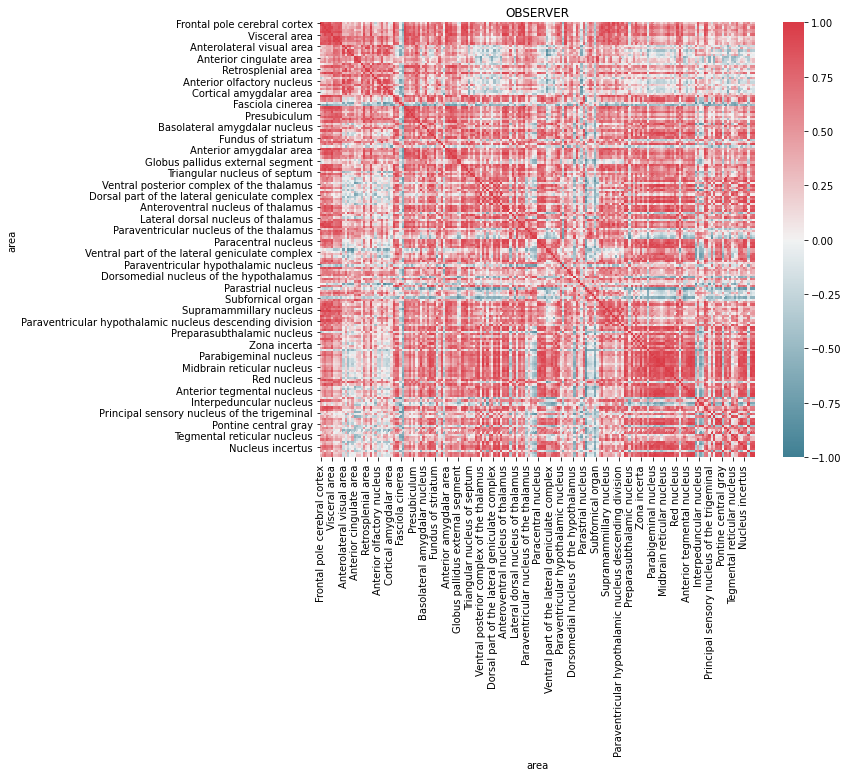

In [24]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(ace.cross_corr(df_noshock_ncells),
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('NO SHOCK')
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(ace.cross_corr(df_demonstrator_ncells),
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('DEMONSTRATOR')
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(ace.cross_corr(df_observer_ncells),
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('OBSERVER')

# Calculate t-tests density across groups per area

In [25]:
df_noshock_density, df_demonstrator_density, df_observer_density = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='density')
df_ttest_density = ace.test_across_groups([df_noshock_density,
                                          df_demonstrator_density,
                                          df_observer_density],
                                        groups=['noshock',
                                               'demonstrator',
                                               'observer'],
                                        test='mannwhitneyu')
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_density = df_ttest_density.dropna(axis=0,
                                   how='all',
                                   subset=['pval_noshock_vs_demonstrator',
                                          'pval_noshock_vs_observer',
                                          'pval_demonstrator_vs_observer'])

In [26]:
find_significant_areas(dictionary=dict_results_across_mice, 
                       experimental_groups=experimental_groups,
                       value='density',
                       test='mannwhitneyu',
                      alpha=0.05).to_csv('significant_areas_non_param_test_density.csv',
                                        index=False)
df_ttest_density.to_csv('df_nonparametrictest_density.csv', index=False)

# Calculate t-tests energy across groups per area

In [27]:
df_noshock_energy, df_demonstrator_energy, df_observer_energy = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='energy')
df_ttest_energy = ace.test_across_groups([df_noshock_energy,
                                          df_demonstrator_energy,
                                          df_observer_energy],
                                        groups=['noshock',
                                               'demonstrator',
                                               'observer'],
                                        test='mannwhitneyu')
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_energy = df_ttest_energy.dropna(axis=0,
                                   how='all',
                                   subset=['pval_noshock_vs_demonstrator',
                                          'pval_noshock_vs_observer',
                                          'pval_demonstrator_vs_observer'])


In [28]:
find_significant_areas(dictionary=dict_results_across_mice, 
                       experimental_groups=experimental_groups,
                       value='energy',
                       test='mannwhitneyu',
                      alpha=0.05).to_csv('significant_areas_non_param_test_energy.csv',
                                        index=False)
df_ttest_ncells.to_csv('df_nonparametrictest_energy.csv', index=False)

In [29]:
df_ttest_not_null_energy.sort_values(
    by='pval_noshock_vs_demonstrator')[['area', 'pval_noshock_vs_demonstrator']][0:20].set_index('area')

,pval_noshock_vs_demonstrator
area,
Anterior hypothalamic area,0.00108251
Lateral strip of striatum,0.00108251
Retroethmoid nucleus,0.00108251
Superior salivatory nucleus,0.00108251
Pineal body,0.00108251
Substantia nigra lateral part,0.00108251
Nucleus circularis,0.00108251
Suprachiasmatic preoptic nucleus,0.00108251
Lateral tegmental nucleus,0.00108251


In [30]:
df_ttest_not_null_energy.sort_values(
    by='pval_noshock_vs_observer')[['area', 'pval_noshock_vs_observer']][0:45].set_index('area')

,pval_noshock_vs_observer
area,
Pontine reticular nucleus ventral part,0.00108251
Lateral strip of striatum,0.00108251
Superior salivatory nucleus,0.00108251
Intercollicular nucleus,0.00108251
Pineal body,0.00108251
Retroethmoid nucleus,0.00108251
Suprachiasmatic preoptic nucleus,0.00108251
Lateral tegmental nucleus,0.00108251
Anterior hypothalamic area,0.00108251


In [31]:
df_ttest_not_null_energy.sort_values(
    by='pval_demonstrator_vs_observer')[['area', 'pval_demonstrator_vs_observer']][0:10].set_index('area')

,pval_demonstrator_vs_observer
area,
Lateral strip of striatum,0.00108251
Nucleus circularis,0.00108251
Pineal body,0.00108251
Intercollicular nucleus,0.00108251
Substantia nigra lateral part,0.00108251
Anterior hypothalamic area,0.00108251
Lateral tegmental nucleus,0.00108251
Suprachiasmatic preoptic nucleus,0.00108251
Superior salivatory nucleus,0.00108251


In [32]:
corr_matrix_noshock_energy = ace.cross_corr(df_noshock_energy)
corr_matrix_demonstrator_energy = ace.cross_corr(df_demonstrator_energy)
corr_matrix_observer_energy = ace.cross_corr(df_observer_energy)

Text(0.5, 1.0, 'OBSERVER')

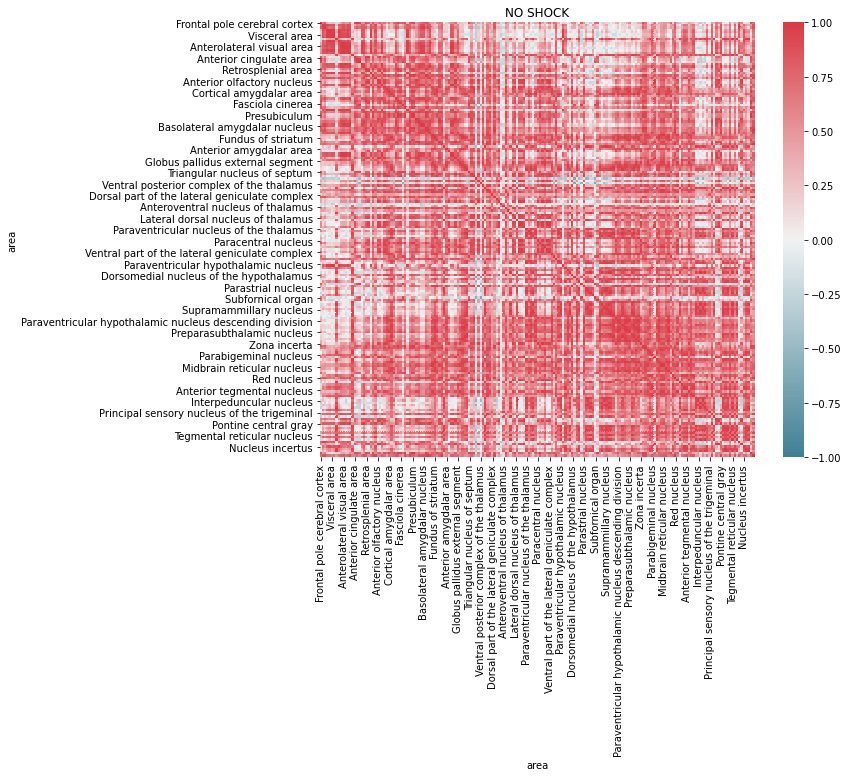

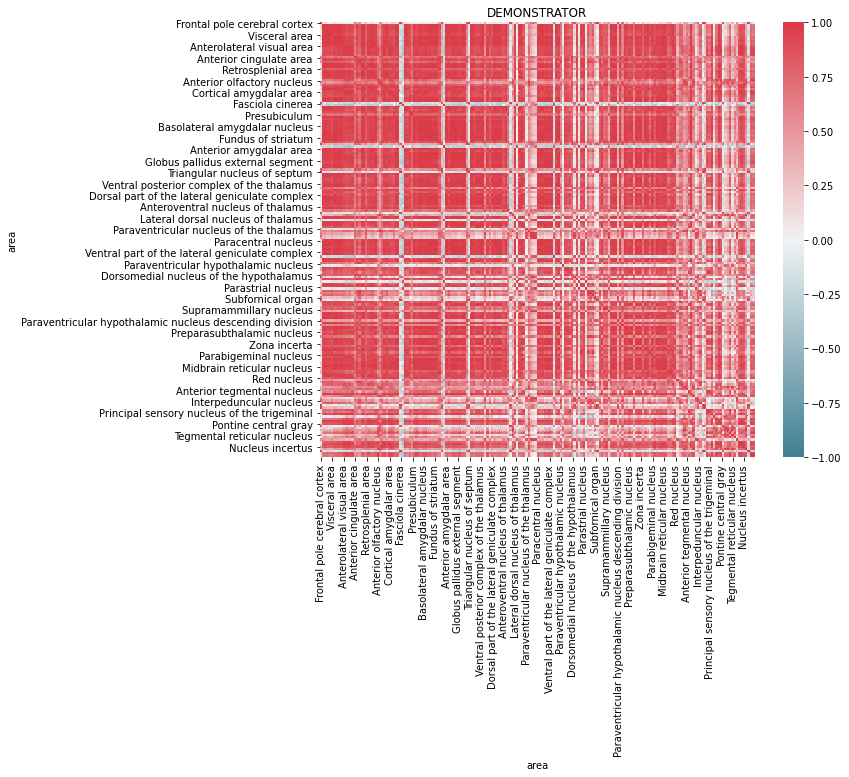

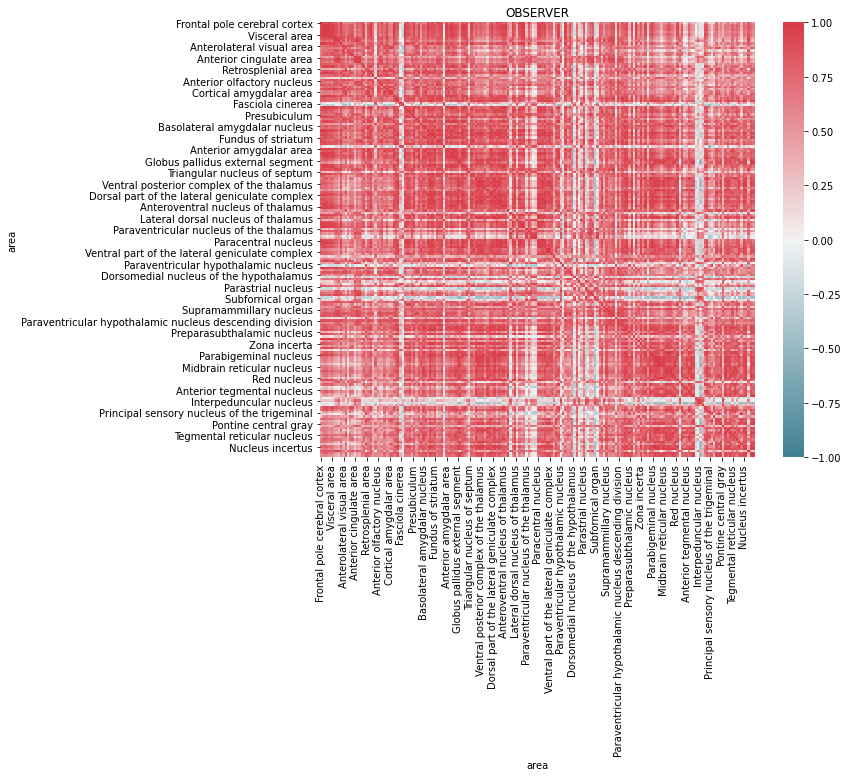

In [33]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(ace.cross_corr(df_noshock_energy),
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('NO SHOCK')
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(ace.cross_corr(df_demonstrator_energy),
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('DEMONSTRATOR')
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(ace.cross_corr(df_observer_energy),
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('OBSERVER')

# Calculate relative density

In [34]:
df_noshock_rd, df_demonstrator_rd, df_observer_rd = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='relative_density')
df_ttest_rd = ace.test_across_groups([df_noshock_rd,
                                          df_demonstrator_rd,
                                          df_observer_rd],
                                        groups=['noshock',
                                               'demonstrator',
                                               'observer'],
                                        test='mannwhitneyu')
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_rd = df_ttest_rd.dropna(axis=0,
                                   how='all',
                                   subset=['pval_noshock_vs_demonstrator',
                                          'pval_noshock_vs_observer',
                                          'pval_demonstrator_vs_observer'])

In [35]:
find_significant_areas(dictionary=dict_results_across_mice, 
                       experimental_groups=experimental_groups,
                       value='relative_density',
                       test='mannwhitneyu',
                      alpha=0.05).to_csv('significant_areas_non_param_test_relative_density.csv',
                                        index=False)
df_ttest_ncells.to_csv('df_nonparametrictest_relative_density.csv', index=False)

In [36]:
df_ttest_not_null_rd.sort_values(
    by='pval_noshock_vs_demonstrator')[['area', 'pval_noshock_vs_demonstrator']][0:30].set_index('area')

,pval_noshock_vs_demonstrator
area,
Intercollicular nucleus,0.00108251
Suprachiasmatic preoptic nucleus,0.00108251
Lateral strip of striatum,0.00108251
Retroethmoid nucleus,0.00108251
Anterior hypothalamic area,0.00108251
Nucleus circularis,0.00108251
Pineal body,0.00108251
Lateral tegmental nucleus,0.00108251
Cortical amygdalar area,0.00108251


In [37]:
df_ttest_not_null_rd.sort_values(
    by='pval_noshock_vs_observer')[['area', 'pval_noshock_vs_observer']][0:20].set_index('area')

,pval_noshock_vs_observer
area,
Anterior hypothalamic area,0.00108251
Lateral tegmental nucleus,0.00108251
Nucleus circularis,0.00108251
Retroethmoid nucleus,0.00108251
Lateral strip of striatum,0.00108251
Pontine reticular nucleus ventral part,0.00108251
Superior salivatory nucleus,0.00108251
Substantia nigra lateral part,0.00108251
Intercollicular nucleus,0.00108251


In [38]:
df_ttest_not_null_rd.sort_values(
    by='pval_demonstrator_vs_observer')[['area', 'pval_demonstrator_vs_observer']][0:20].set_index('area')

,pval_demonstrator_vs_observer
area,
Substantia nigra lateral part,0.00108251
Lateral tegmental nucleus,0.00108251
Lateral strip of striatum,0.00108251
Pontine reticular nucleus ventral part,0.00108251
Suprachiasmatic preoptic nucleus,0.00108251
Anterior hypothalamic area,0.00108251
Nucleus circularis,0.00108251
Pineal body,0.00108251
Superior salivatory nucleus,0.00108251


In [39]:
corr_matrix_noshock_rd = ace.cross_corr(df_noshock_rd)
corr_matrix_demonstrator_rd = ace.cross_corr(df_demonstrator_rd)
corr_matrix_observer_rd = ace.cross_corr(df_observer_rd)

Text(0.5, 1.0, 'OBSERVER')

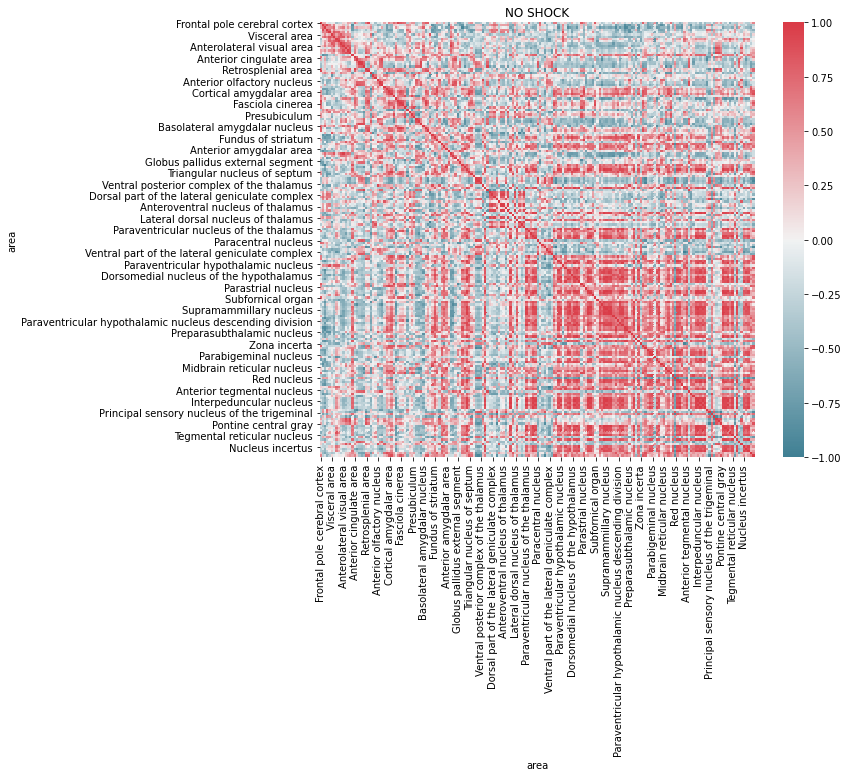

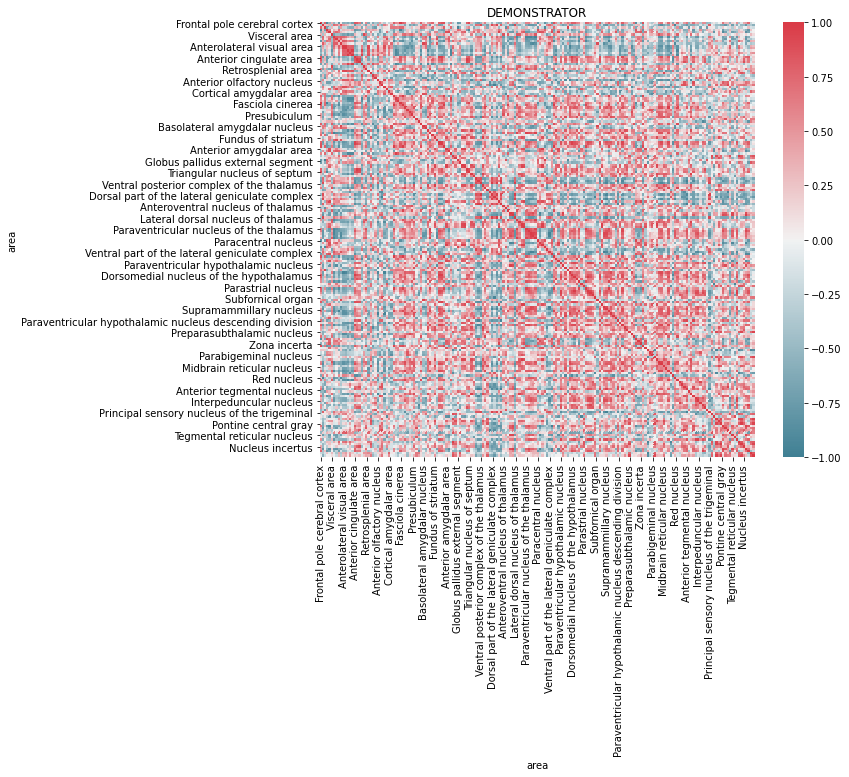

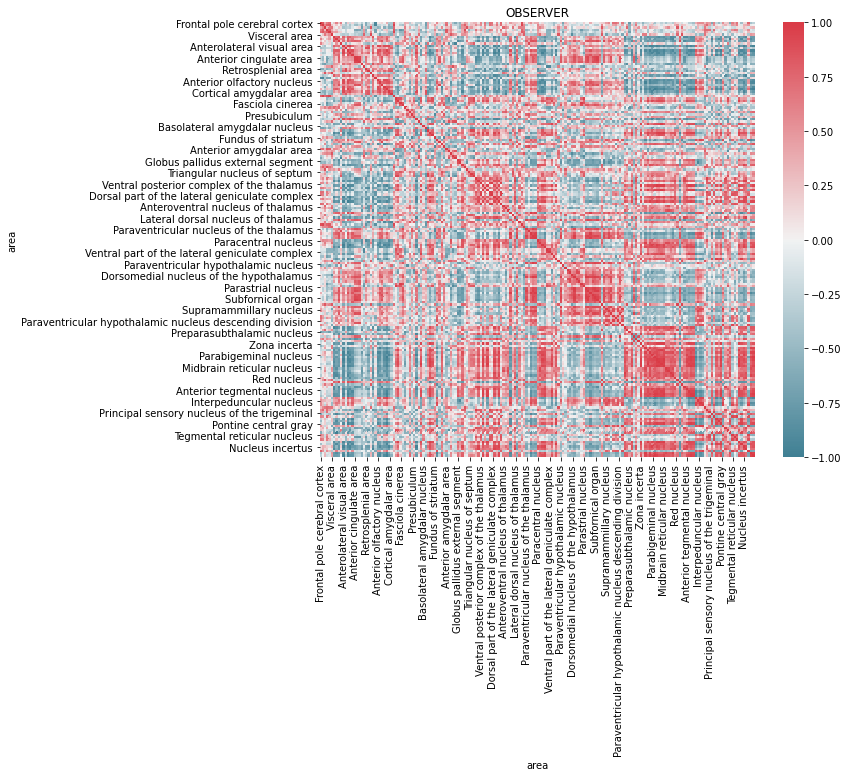

In [40]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(ace.cross_corr(df_noshock_rd),
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('NO SHOCK')
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(ace.cross_corr(df_demonstrator_rd),
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('DEMONSTRATOR')
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(ace.cross_corr(df_observer_rd),
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('OBSERVER')

# Correlation with behavior

In [41]:
#load behavioral data and removing mouse 12
behavior = pd.read_excel('/home/stella/Documents/Torino/projects/SexualImprinting/PISA/subs_FOS_EC.xlsx', 
                         index_col=0).drop(11)

In [42]:
behavior

,cage,label,sex,geno,role,EC_amp_0,EC_lat_0,mouse
0,CLT_5,000,M,WT,NOS,1.055338,2.05,BL15noshock
1,CLT_3,R00,M,WT,NOS,-0.796098,3.00,BL7noshock
2,CLT_3,0R0,M,WT,OBS,1.067573,2.40,BL2observer
3,CLT_9,R00,F,WT,OBS,1.114847,1.70,BL21observer
4,CLT_1,000,F,WT,OBS,3.932445,1.00,BL8observer
5,CLT_7,00R,F,WT,OBS,9.881270,1.70,BL18observer
6,CLT_2,0R0,F,WT,NOS,-0.534185,1.20,BL1noshock
7,CLT_7,000,F,WT,NOS,0.140642,2.05,BL19noshock
8,CLT_6,0R0,M,WT,OBS,1.250897,2.80,BL10observer
9,CLT_6,00B,M,WT,NOS,0.920259,1.15,BL11noshock


In [43]:
behavior_noshock = behavior[behavior['role'] == 'NOS'][['EC_amp_0', 'EC_lat_0', 'mouse']].reset_index(drop=True)
behavior_observer = behavior[behavior['role'] == 'OBS'][['EC_amp_0', 'EC_lat_0', 'mouse']].reset_index(drop=True)

In [44]:
behavior_observer

,EC_amp_0,EC_lat_0,mouse
0,1.067573,2.40,BL2observer
1,1.114847,1.70,BL21observer
2,3.932445,1.00,BL8observer
3,9.881270,1.70,BL18observer
4,1.250897,2.80,BL10observer
5,2.324617,1.40,BL5observer
6,1.573428,2.05,BL16observer


<AxesSubplot:xlabel='geno', ylabel='EC_lat_0'>

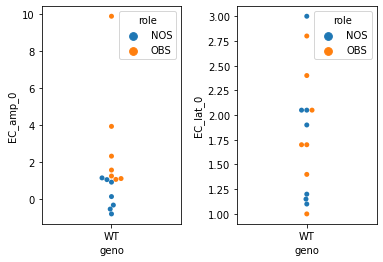

In [45]:
# make plot
fig, axes = plt.subplots(1,2)
plt.subplots_adjust(wspace=0.4)
# Draw a categorical scatterplot to show each observation
sns.swarmplot(data=behavior, y="EC_amp_0",x='geno',
                   hue="role", ax=axes[0])
sns.swarmplot(data=behavior, y="EC_lat_0",x='geno',
                   hue="role", ax=axes[1])

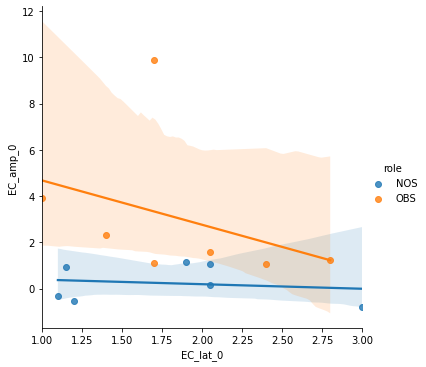

In [46]:
g = sns.lmplot(
    data=behavior,
    x="EC_lat_0", y="EC_amp_0", hue="role",
    height=5
)

# Plots corr tests

In [47]:
significant_areas = ace.select_significant_areas(dictionary=dict_results_across_mice, 
                                             experimental_groups=experimental_groups, 
                                             batch='PISA',
                                             test='mannwhitneyu', 
                                             threshold_test=0.05,
                                             threshold_pls=2.56,
                                             value_test='density', 
                                             value_pls='relative_density')

In [48]:
areas_ttest_acronyms = set([volumes[volumes['safe_name']==area]['acronym'].values[0] \
                            for area in significant_areas])

In [49]:
#reorder behavioral data based on df_group
behavior_observer = behavior_observer.set_index('mouse').\
            loc[df_observer_density.set_index('area').columns.to_list(), :].reset_index()
behavior_noshock = behavior_noshock.set_index('mouse').\
            loc[df_noshock_density.set_index('area').columns.to_list(), :].reset_index()

/home/stella/anaconda2/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/stella/anaconda2/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


<AxesSubplot:>

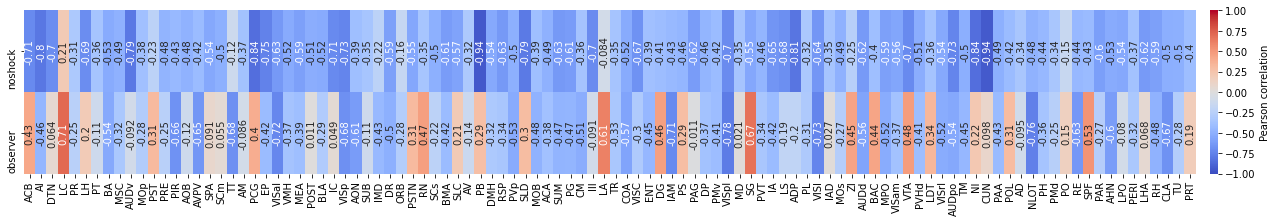

In [50]:
corr_ncells, pvalue = ace.compute_corr_pvalue(dfs_groups=[df_noshock_density, df_observer_density], 
                                   group_labels=['noshock', 'observer'],
                                   volumes=volumes, 
                                   behavioral_data=[behavior_noshock['EC_amp_0'],
                                                      behavior_observer['EC_amp_0']],
                                   significant_areas=list(areas_ttest_acronyms))
# put X if pvalue is significant
fig, axes = plt.subplots(figsize=(25,3))
sns.heatmap(corr_ncells, ax=axes, cmap='coolwarm', vmin=-1, vmax=+1, 
                             cbar_kws={'label': 'Pearson correlation',"pad":0.01},
           annot=True, annot_kws={'rotation': 90})

/home/stella/anaconda2/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/stella/anaconda2/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


<AxesSubplot:>

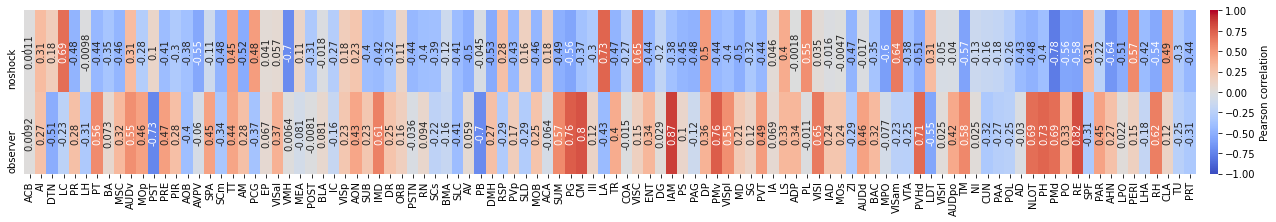

In [51]:
corr_ncells, pvalue = ace.compute_corr_pvalue(dfs_groups=[df_noshock_density, df_observer_density], 
                                   group_labels=['noshock', 'observer'],
                                   volumes=volumes, 
                                   behavioral_data=[behavior_noshock['EC_lat_0'],
                                                      behavior_observer['EC_lat_0']],
                                   significant_areas=list(areas_ttest_acronyms))
# put X if pvalue is significant
fig, axes = plt.subplots(figsize=(25,3))
sns.heatmap(corr_ncells, ax=axes, cmap='coolwarm', vmin=-1, vmax=+1, 
                             cbar_kws={'label': 'Pearson correlation',"pad":0.01},
           annot=True, annot_kws={'rotation': 90})

# Check delta tra correlazioni nei gruppi + distribuzioni correlazioni tra gruppi

Text(0.5, 1.0, 'Observer')

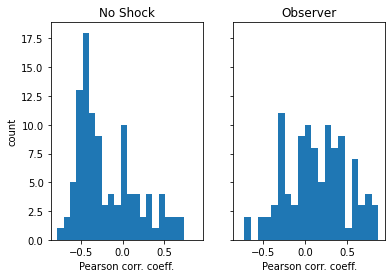

In [52]:
fig, axes = plt.subplots(1,2, sharex=True, sharey=True)
axes[0].hist(corr_ncells.T['noshock'], bins=20)
axes[1].hist(corr_ncells.T['observer'], bins=20)
axes[0].set_ylabel('count')
axes[0].set_xlabel('Pearson corr. coeff.')
axes[1].set_xlabel('Pearson corr. coeff.')
axes[0].set_title('No Shock')
axes[1].set_title('Observer')

# Plots correlation density vs EC_amp_0 delle aree viste da ste

In [53]:
aree_ste = ['Agranular insular area',
           'Retrosplenial area',
           'Anterior olfactory nucleus',
           'Postsubiculum',
           'Presubiculum',
           'Claustrum',
           'Endopiriform nucleus',
           'Basolateral amygdalar nucleus',
           'Intercalated amygdalar nucleus',
           'Medial amygdalar nucleus',
           'Lateral hypothalamic area',
           'Superior colliculus sensory related',
           'Inferior colliculus']

## For pupil amplitude

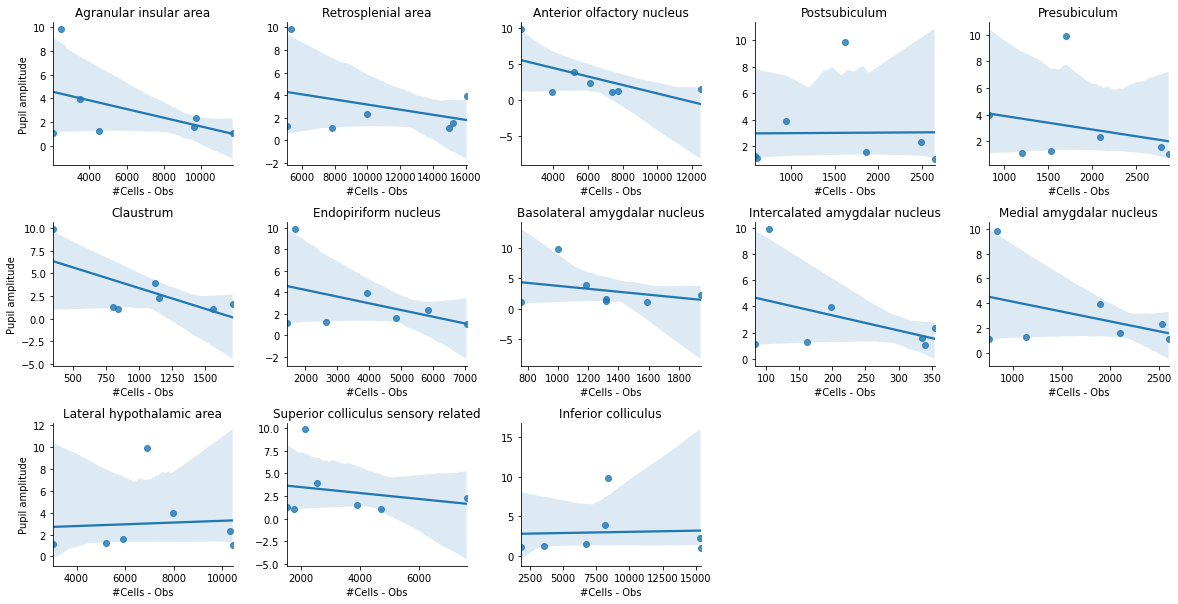

In [54]:
fig, axes  = plt.subplots(3,5, figsize=(20,10))
plt.subplots_adjust(hspace=0.4, wspace=0.3)
for i, area in enumerate(aree_ste):
    data = pd.DataFrame(columns=['n_cells', 'behavior', 'mouse'])
    data['n_cells'] = df_observer_ncells.set_index('area').T[area].values
    data['subject'] = df_observer_ncells.set_index('area').T[area].index
    data['behavior'] = [behavior_observer[behavior_observer['mouse']==mouse]["EC_amp_0"].item() \
                        for mouse in data['subject'].values]
    g = sns.regplot(data=data, x='n_cells', 
                   y='behavior', ax=axes.flat[i],
                   fit_reg=True)
    axes.flat[i].set_title(area)
    axes.flat[i].set_title(area)
    axes.flat[i].spines['top'].set_visible(False)
    axes.flat[i].spines['right'].set_visible(False)
    axes.flat[i].set_xlabel("#Cells - Obs")
    if i not in [0,5,10]:
        axes.flat[i].set_ylabel("")
    else:
        axes.flat[i].set_ylabel("Pupil amplitude")
fig.delaxes(axes.flat[13])
fig.delaxes(axes.flat[14])
plt.savefig('correlation_pupil_amplitude.png')
plt.savefig('correlation_pupil_amplitude.svg')

## For pupil latency

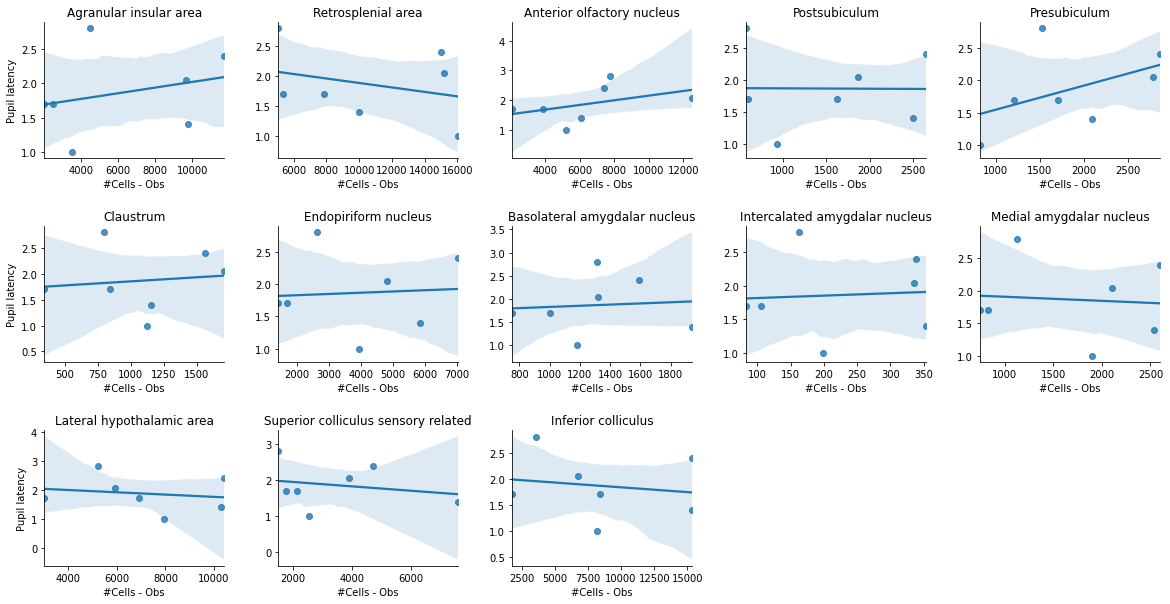

In [55]:
fig, axes  = plt.subplots(3,5, figsize=(20,10))
plt.subplots_adjust(hspace=0.5, wspace=0.3)
for i, area in enumerate(aree_ste):
    data = pd.DataFrame(columns=['n_cells', 'behavior'])
    data['n_cells'] = df_observer_ncells.set_index('area').T[area].values
    data['subject'] = df_observer_ncells.set_index('area').T[area].index
    data['behavior'] = [behavior_observer[behavior_observer['mouse']==mouse]["EC_lat_0"].item() \
                        for mouse in data['subject'].values]
    g = sns.regplot(data=data, x='n_cells', 
                   y='behavior', ax=axes.flat[i])
    axes.flat[i].set_title(area)
    axes.flat[i].set_title(area)
    axes.flat[i].spines['top'].set_visible(False)
    axes.flat[i].spines['right'].set_visible(False)
    axes.flat[i].set_xlabel("#Cells - Obs")
    if i not in [0,5,10]:
        axes.flat[i].set_ylabel("")
    else:
        axes.flat[i].set_ylabel("Pupil latency")
fig.delaxes(axes.flat[13])
fig.delaxes(axes.flat[14])
plt.savefig('correlation_pupil_latency.png')
plt.savefig('correlation_pupil_latency.svg')

#  Overlap aree attivate (noshock vs observer) vs (noshock vs demonstrator)

In [56]:
area_noshock_vs_demonstrator = set([volumes[volumes['safe_name']==area]['acronym'].values[0] for area in 
                                 df_ttest_not_null_rd[
    df_ttest_not_null_rd['pval_noshock_vs_demonstrator']<0.05]['area'].values])
area_noshock_vs_observer = set([volumes[volumes['safe_name']==area]['acronym'].values[0] for area in 
                                 df_ttest_not_null_rd[
    df_ttest_not_null_rd['pval_noshock_vs_observer']<0.05]['area'].values])

In [57]:
# intersection significant areas with relative density
area_noshock_vs_demonstrator.intersection(area_noshock_vs_observer) 

{'AHA',
 'AON',
 'BMA',
 'CLA',
 'COA',
 'CP',
 'ENT',
 'EP',
 'FS',
 'GPe',
 'IAM',
 'InCo',
 'LSS',
 'LTN',
 'NC',
 'PIN',
 'PIR',
 'PPN',
 'PRNv',
 'PSCH',
 'RE',
 'REth',
 'RN',
 'RR',
 'SNl',
 'SSN',
 'TT',
 'V',
 'VISal',
 'VISl',
 'VISp',
 'VISpl'}

In [58]:
# areas that are significant in demonstrator but not in observer
area_noshock_vs_demonstrator.difference(area_noshock_vs_observer) 

{'AI',
 'AUDpo',
 'AUDv',
 'IA',
 'IMD',
 'LT',
 'MOB',
 'NLOT',
 'ORB',
 'PP',
 'PRNc',
 'PRNr',
 'PS',
 'RH',
 'SI',
 'SNc',
 'SNr',
 'TR'}

In [59]:
# areas significant in observer and not in demonstrator
area_noshock_vs_observer.difference(area_noshock_vs_demonstrator) 

{'CEA', 'DR', 'DTN', 'POST', 'PR', 'PT', 'RSP', 'SG', 'VISam', 'VISrl'}

# Histograms of counts of all measures across significant areas

## relative density

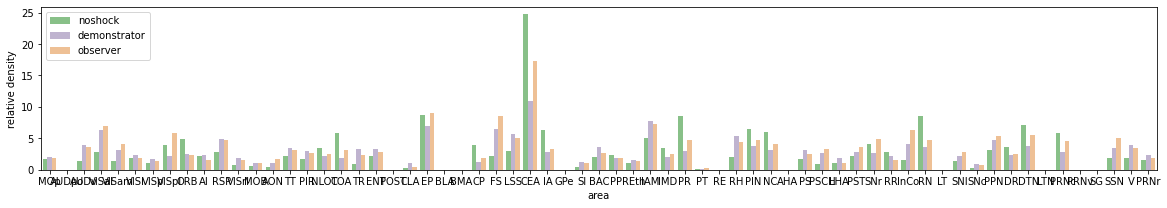

In [60]:
areas_ttest = np.unique(np.hstack([
    df_ttest_not_null_rd[df_ttest_not_null_rd['pval_noshock_vs_demonstrator']<0.05]['area'].values,
    df_ttest_not_null_rd[df_ttest_not_null_rd['pval_noshock_vs_observer']<0.05]['area'].values,
    df_ttest_not_null_rd[df_ttest_not_null_rd['pval_demonstrator_vs_observer']<0.05]['area'].values]))
areas_ttest_acronyms = [volumes[volumes['safe_name']==area]['acronym'].values[0] for area in areas_ttest]
areas_ttest_acronyms = [area for area in volumes['acronym'].values if area in areas_ttest_acronyms]

control = pd.DataFrame(columns=['area', 'relative density', 'group'])
fam = pd.DataFrame(columns=['area', 'relative density', 'group'])
unfam = pd.DataFrame(columns=['area', 'relative density', 'group'])
control['area'] = areas_ttest_acronyms
control['group'] = ['noshock' for area in areas_ttest]
control['relative density'] = [df_noshock_rd.set_index('area').loc[area].mean() for area in areas_ttest]

fam['area'] = areas_ttest_acronyms
fam['group'] = ['demonstrator' for area in areas_ttest]
fam['relative density'] = [df_demonstrator_rd.set_index('area').loc[area].mean() for area in areas_ttest]

unfam['area'] = areas_ttest_acronyms
unfam['group'] = ['observer' for area in areas_ttest]
unfam['relative density'] = [df_observer_rd.set_index('area').loc[area].mean() for area in areas_ttest]
without_father = control.append(fam).append(unfam)

f, ax = plt.subplots(ncols=1, nrows=1, gridspec_kw={'hspace':0.05}, figsize=(20,3))
sns.barplot(
    data=without_father,
    x="area", y="relative density", hue="group", palette="Accent", ax=ax)
ax.legend().set_title('')

## number of cells

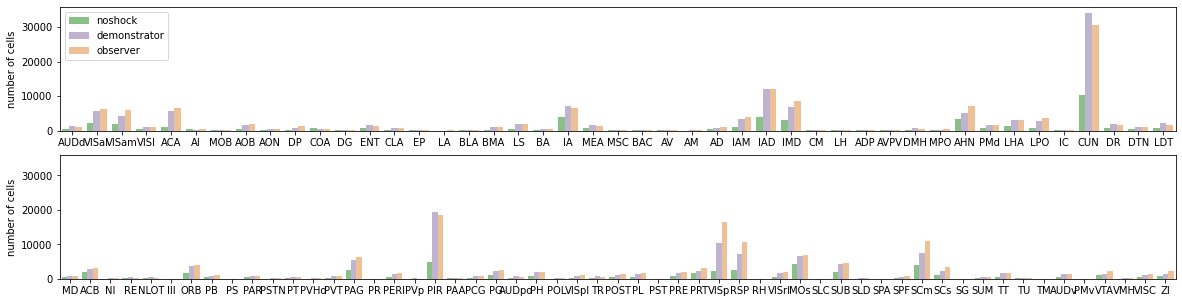

In [61]:
##### stack1
areas_ttest = np.unique(np.hstack([
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_noshock_vs_demonstrator']<0.05]['area'].values,
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_noshock_vs_observer']<0.05]['area'].values,
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_demonstrator_vs_observer']<0.05]['area'].values]))[:45]

areas_ttest_acronyms = [volumes[volumes['safe_name']==area]['acronym'].values[0] for area in areas_ttest]
areas_ttest_acronyms = [area for area in volumes['acronym'].values if area in areas_ttest_acronyms]

control = pd.DataFrame(columns=['area', 'number of cells', 'group'])
fam = pd.DataFrame(columns=['area', 'number of cells', 'group'])
unfam = pd.DataFrame(columns=['area', 'number of cells', 'group'])
control['area'] = areas_ttest_acronyms
control['group'] = ['noshock' for area in areas_ttest]
control['number of cells'] = [df_noshock_ncells.set_index('area').loc[area].mean() for area in areas_ttest]

fam['area'] = areas_ttest_acronyms
fam['group'] = ['demonstrator' for area in areas_ttest]
fam['number of cells'] = [df_demonstrator_ncells.set_index('area').loc[area].mean() for area in areas_ttest]

unfam['area'] = areas_ttest_acronyms
unfam['group'] = ['observer' for area in areas_ttest]
unfam['number of cells'] = [df_observer_ncells.set_index('area').loc[area].mean() for area in areas_ttest]
without_father1 = control.append(fam).append(unfam)

#stack 2

areas_ttest = np.unique(np.hstack([
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_noshock_vs_demonstrator']<0.05]['area'].values,
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_noshock_vs_observer']<0.05]['area'].values,
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_demonstrator_vs_observer']<0.05]['area'].values]))[45:]

areas_ttest_acronyms = [volumes[volumes['safe_name']==area]['acronym'].values[0] for area in areas_ttest]

control = pd.DataFrame(columns=['area', 'number of cells', 'group'])
fam = pd.DataFrame(columns=['area', 'number of cells', 'group'])
unfam = pd.DataFrame(columns=['area', 'number of cells', 'group'])
control['area'] = areas_ttest_acronyms
control['group'] = ['noshock' for area in areas_ttest]
control['number of cells'] = [df_noshock_ncells.set_index('area').loc[area].mean() for area in areas_ttest]

fam['area'] = areas_ttest_acronyms
fam['group'] = ['demonstrator' for area in areas_ttest]
fam['number of cells'] = [df_demonstrator_ncells.set_index('area').loc[area].mean() for area in areas_ttest]

unfam['area'] = areas_ttest_acronyms
unfam['group'] = ['observer' for area in areas_ttest]
unfam['number of cells'] = [df_observer_ncells.set_index('area').loc[area].mean() for area in areas_ttest]
without_father2 = control.append(fam).append(unfam)

f, ax = plt.subplots(ncols=1, nrows=2, gridspec_kw={'hspace':0.2}, figsize=(20,5), sharey=True)
sns.barplot(
    data=without_father1,
    x="area", y="number of cells", hue="group", palette="Accent", ax=ax[0])
ax[0].set_xlabel('')
sns.barplot(
    data=without_father2,
    x="area", y="number of cells", hue="group", palette="Accent", ax=ax[1])
ax[1].set_xlabel('')
ax[1].legend_.remove()
ax[0].legend().set_title('')

## density

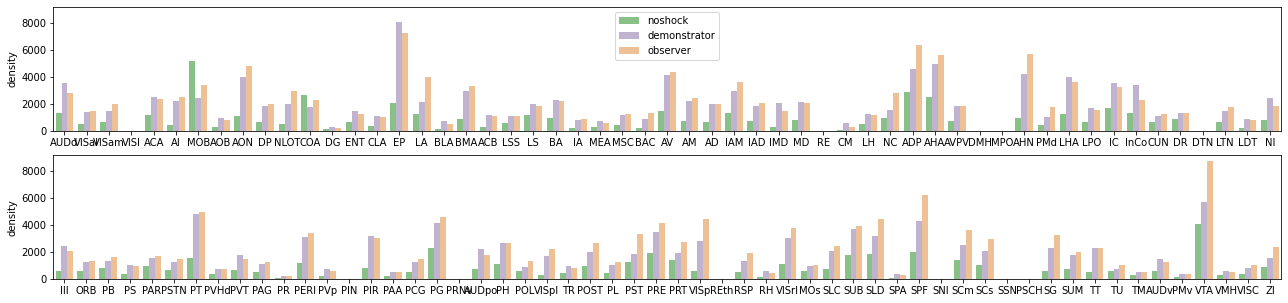

In [70]:
# stack1
areas_ttest = np.unique(np.hstack([
    df_ttest_not_null_density[df_ttest_not_null_density['pval_noshock_vs_demonstrator']<0.05]['area'].values,
    df_ttest_not_null_density[df_ttest_not_null_density['pval_noshock_vs_observer']<0.05]['area'].values,
    df_ttest_not_null_density[df_ttest_not_null_density['pval_demonstrator_vs_observer']<0.05]['area'].values]))[:55]

areas_ttest_acronyms = [volumes[volumes['safe_name']==area]['acronym'].values[0] for area in areas_ttest]
areas_ttest_acronyms = [area for area in volumes['acronym'].values if area in areas_ttest_acronyms]

control = pd.DataFrame(columns=['area', 'density', 'group'])
fam = pd.DataFrame(columns=['area', 'density', 'group'])
unfam = pd.DataFrame(columns=['area', 'density', 'group'])
control['area'] = areas_ttest_acronyms
control['group'] = ['noshock' for area in areas_ttest]
control['density'] = [df_noshock_density.set_index('area').loc[area].mean() for area in areas_ttest]

fam['area'] = areas_ttest_acronyms
fam['group'] = ['demonstrator' for area in areas_ttest]
fam['density'] = [df_demonstrator_density.set_index('area').loc[area].mean() for area in areas_ttest]

unfam['area'] = areas_ttest_acronyms
unfam['group'] = ['observer' for area in areas_ttest]
unfam['density'] = [df_observer_density.set_index('area').loc[area].mean() for area in areas_ttest]
without_father1 = control.append(fam).append(unfam)

#stack 2

areas_ttest = np.unique(np.hstack([
    df_ttest_not_null_density[df_ttest_not_null_density['pval_noshock_vs_demonstrator']<0.05]['area'].values,
    df_ttest_not_null_density[df_ttest_not_null_density['pval_noshock_vs_observer']<0.05]['area'].values,
    df_ttest_not_null_density[df_ttest_not_null_density['pval_demonstrator_vs_observer']<0.05]['area'].values]))[55:]

areas_ttest_acronyms = [volumes[volumes['safe_name']==area]['acronym'].values[0] for area in areas_ttest]


control = pd.DataFrame(columns=['area', 'density', 'group'])
fam = pd.DataFrame(columns=['area', 'density', 'group'])
unfam = pd.DataFrame(columns=['area', 'density', 'group'])
control['area'] = areas_ttest_acronyms
control['group'] = ['noshock' for area in areas_ttest]
control['density'] = [df_noshock_density.set_index('area').loc[area].mean() for area in areas_ttest]

fam['area'] = areas_ttest_acronyms
fam['group'] = ['demonstrator' for area in areas_ttest]
fam['density'] = [df_demonstrator_density.set_index('area').loc[area].mean() for area in areas_ttest]

unfam['area'] = areas_ttest_acronyms
unfam['group'] = ['observer' for area in areas_ttest]
unfam['density'] = [df_observer_density.set_index('area').loc[area].mean() for area in areas_ttest]
without_father2 = control.append(fam).append(unfam)

f, ax = plt.subplots(ncols=1, nrows=2, gridspec_kw={'hspace':0.2}, figsize=(22,5), sharey=True)
sns.barplot(
    data=without_father1,
    x="area", y="density", hue="group", palette="Accent", ax=ax[0])
ax[0].set_xlabel('')
sns.barplot(
    data=without_father2,
    x="area", y="density", hue="group", palette="Accent", ax=ax[1])
ax[1].legend_.remove()
ax[1].set_xlabel('')
ax[0].legend().set_title('')

## energy

Text(0.5, 0, '')

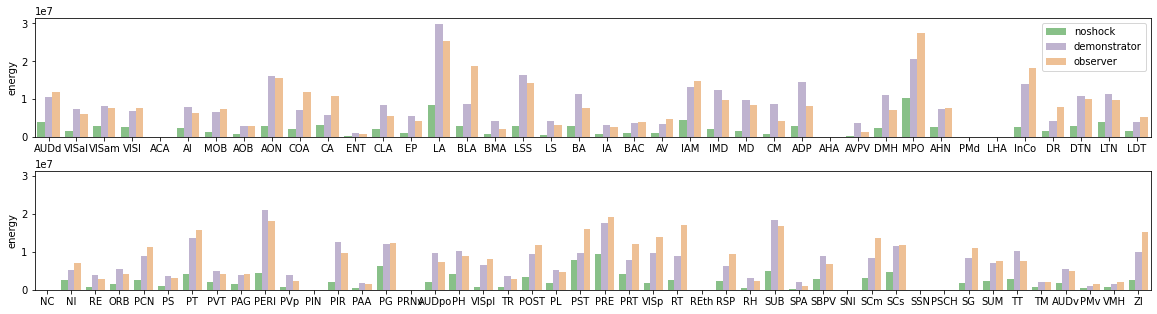

In [65]:
# stack1
areas_ttest = np.unique(np.hstack([
    df_ttest_not_null_energy[df_ttest_not_null_energy['pval_noshock_vs_demonstrator']<0.05]['area'].values,
    df_ttest_not_null_energy[df_ttest_not_null_energy['pval_noshock_vs_observer']<0.05]['area'].values,
    df_ttest_not_null_energy[df_ttest_not_null_energy['pval_demonstrator_vs_observer']<0.05]['area'].values]))[:40]

areas_ttest_acronyms = [volumes[volumes['safe_name']==area]['acronym'].values[0] for area in areas_ttest]
areas_ttest_acronyms = [area for area in volumes['acronym'].values if area in areas_ttest_acronyms]

control = pd.DataFrame(columns=['area', 'energy', 'group'])
fam = pd.DataFrame(columns=['area', 'energy', 'group'])
unfam = pd.DataFrame(columns=['area', 'energy', 'group'])
control['area'] = areas_ttest_acronyms
control['group'] = ['noshock' for area in areas_ttest]
control['energy'] = [df_noshock_energy.set_index('area').loc[area].mean() for area in areas_ttest]

fam['area'] = areas_ttest_acronyms
fam['group'] = ['demonstrator' for area in areas_ttest]
fam['energy'] = [df_demonstrator_energy.set_index('area').loc[area].mean() for area in areas_ttest]

unfam['area'] = areas_ttest_acronyms
unfam['group'] = ['observer' for area in areas_ttest]
unfam['energy'] = [df_observer_energy.set_index('area').loc[area].mean() for area in areas_ttest]
without_father1 = control.append(fam).append(unfam)

#stack 2

areas_ttest = np.unique(np.hstack([
    df_ttest_not_null_energy[df_ttest_not_null_energy['pval_noshock_vs_demonstrator']<0.05]['area'].values,
    df_ttest_not_null_energy[df_ttest_not_null_energy['pval_noshock_vs_observer']<0.05]['area'].values,
    df_ttest_not_null_energy[df_ttest_not_null_energy['pval_demonstrator_vs_observer']<0.05]['area'].values]))[40:]

areas_ttest_acronyms = [volumes[volumes['safe_name']==area]['acronym'].values[0] for area in areas_ttest]


control = pd.DataFrame(columns=['area', 'energy', 'group'])
fam = pd.DataFrame(columns=['area', 'energy', 'group'])
unfam = pd.DataFrame(columns=['area', 'energy', 'group'])
control['area'] = areas_ttest_acronyms
control['group'] = ['noshock' for area in areas_ttest]
control['energy'] = [df_noshock_energy.set_index('area').loc[area].mean() for area in areas_ttest]

fam['area'] = areas_ttest_acronyms
fam['group'] = ['demonstrator' for area in areas_ttest]
fam['energy'] = [df_demonstrator_energy.set_index('area').loc[area].mean() for area in areas_ttest]

unfam['area'] = areas_ttest_acronyms
unfam['group'] = ['observer' for area in areas_ttest]
unfam['energy'] = [df_observer_energy.set_index('area').loc[area].mean() for area in areas_ttest]
without_father2 = control.append(fam).append(unfam)

f, ax = plt.subplots(ncols=1, nrows=2, gridspec_kw={'hspace':0.28}, figsize=(20,5), sharey=True)
sns.barplot(
    data=without_father1,
    x="area", y="energy", hue="group", palette="Accent", ax=ax[0])
ax[0].set_xlabel('')
ax[0].legend().set_title('')
sns.barplot(
    data=without_father2,
    x="area", y="energy", hue="group", palette="Accent", ax=ax[1])
ax[1].legend_.remove()
ax[1].set_xlabel('')

# Intersection significant areas (ttest ncells vs energy vs dens vs rel_dens) 
for 
- control vs observer 
- control vs demonstrator
- observer vs demonstrator

In [67]:
ncells_noshock_vs_observer = set([volumes[volumes['safe_name']==area]['acronym'].values[0] for area in 
                                 df_ttest_not_null_ncells[
    df_ttest_not_null_ncells['pval_noshock_vs_observer']<0.05]['area'].values])

energy_noshock_vs_observer = set([volumes[volumes['safe_name']==area]['acronym'].values[0] for area in 
                                 df_ttest_not_null_energy[
    df_ttest_not_null_energy['pval_noshock_vs_observer']<0.05]['area'].values])

rd_noshock_vs_observer = set([volumes[volumes['safe_name']==area]['acronym'].values[0] for area in 
                                 df_ttest_not_null_rd[
    df_ttest_not_null_rd['pval_noshock_vs_observer']<0.05]['area'].values])

density_noshock_vs_observer = set([volumes[volumes['safe_name']==area]['acronym'].values[0] for area in 
                                 df_ttest_not_null_density[
    df_ttest_not_null_density['pval_noshock_vs_observer']<0.05]['area'].values])

print(len(ncells_noshock_vs_observer), len(energy_noshock_vs_observer), len(rd_noshock_vs_observer), len(density_noshock_vs_observer))
ncells_noshock_vs_observer.intersection(
    energy_noshock_vs_observer).intersection(
    rd_noshock_vs_observer).intersection(
    density_noshock_vs_observer)

99 84 42 110


{'AON',
 'BMA',
 'CLA',
 'COA',
 'DR',
 'DTN',
 'ENT',
 'EP',
 'IAM',
 'PIR',
 'POST',
 'PT',
 'RE',
 'RSP',
 'SG',
 'TT',
 'VISal',
 'VISam',
 'VISl',
 'VISp',
 'VISpl'}

In [68]:
ncells_noshock_vs_demonstrator = set([volumes[volumes['safe_name']==area]['acronym'].values[0] for area in 
                                 df_ttest_not_null_ncells[
    df_ttest_not_null_ncells['pval_noshock_vs_demonstrator']<0.05]['area'].values])

energy_noshock_vs_demonstrator = set([volumes[volumes['safe_name']==area]['acronym'].values[0] for area in 
                                 df_ttest_not_null_energy[
    df_ttest_not_null_energy['pval_noshock_vs_demonstrator']<0.05]['area'].values])

rd_noshock_vs_demonstrator = set([volumes[volumes['safe_name']==area]['acronym'].values[0] for area in 
                                 df_ttest_not_null_rd[
    df_ttest_not_null_rd['pval_noshock_vs_demonstrator']<0.05]['area'].values])

density_noshock_vs_demonstrator = set([volumes[volumes['safe_name']==area]['acronym'].values[0] for area in 
                                 df_ttest_not_null_density[
    df_ttest_not_null_density['pval_noshock_vs_demonstrator']<0.05]['area'].values])

print(len(ncells_noshock_vs_demonstrator), len(energy_noshock_vs_demonstrator), len(rd_noshock_vs_demonstrator), len(density_noshock_vs_demonstrator))
ncells_noshock_vs_demonstrator.intersection(
    energy_noshock_vs_demonstrator).intersection(
    rd_noshock_vs_demonstrator).intersection(
    density_noshock_vs_demonstrator)

46 42 50 57


{'AI',
 'AON',
 'BMA',
 'CLA',
 'COA',
 'ENT',
 'EP',
 'IAM',
 'IMD',
 'MOB',
 'ORB',
 'PIR',
 'RE',
 'RH',
 'TR',
 'TT',
 'VISl',
 'VISp',
 'VISpl'}

In [69]:
ncells_demonstrator_vs_observer = set([volumes[volumes['safe_name']==area]['acronym'].values[0] for area in 
                                 df_ttest_not_null_ncells[
    df_ttest_not_null_ncells['pval_demonstrator_vs_observer']<0.05]['area'].values])

energy_demonstrator_vs_observer = set([volumes[volumes['safe_name']==area]['acronym'].values[0] for area in 
                                 df_ttest_not_null_energy[
    df_ttest_not_null_energy['pval_demonstrator_vs_observer']<0.05]['area'].values])

rd_demonstrator_vs_observer = set([volumes[volumes['safe_name']==area]['acronym'].values[0] for area in 
                                 df_ttest_not_null_rd[
    df_ttest_not_null_rd['pval_demonstrator_vs_observer']<0.05]['area'].values])

density_demonstrator_vs_observer = set([volumes[volumes['safe_name']==area]['acronym'].values[0] for area in 
                                 df_ttest_not_null_density[
    df_ttest_not_null_density['pval_demonstrator_vs_observer']<0.05]['area'].values])

print(len(ncells_demonstrator_vs_observer), len(energy_demonstrator_vs_observer), len(rd_demonstrator_vs_observer), len(density_demonstrator_vs_observer))
ncells_demonstrator_vs_observer.intersection(
    energy_demonstrator_vs_observer).intersection(
    rd_demonstrator_vs_observer).intersection(
    density_demonstrator_vs_observer)

1 11 18 12


set()

# Saving data

In [ ]:
dict_results_across_mice = np.load('dict_results/newvolumes/dict_results_across_mice_PISA.npy', 
                                   allow_pickle=True).item()
# reformat dictionary and subjects
old_keys = list(dict_results_across_mice.keys())
for key in old_keys:
    group = key.split('_')[-1] if key.split('_')[-1][-1]!='2' else key.split('_')[-1][:-1]
    number = key.split('_')[0]
    new_key = 'BL'+number+'_'+group
    dict_results_across_mice[new_key] = dict_results_across_mice[key]
    del dict_results_across_mice[key]
    
#remove BL12_noshock due to biased number of cells
del dict_results_across_mice['BL12_noshock']
subjects = list(dict_results_across_mice.keys())


In [ ]:
experimental_groups = utils.divide_in_exp_groups(list_subjects=subjects,
                                                group_labels=['noshock','demonstrator', 'observer'])

## Saving tables cell counts

In [ ]:
df_noshock_ncells, df_demonstrator_ncells, df_observer_ncells = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='n_cells')

In [ ]:
df_noshock_ncells.to_csv(
    '/home/stella/Documents/Torino/projects/SexualImprinting/PISA/results/df_noshock_ncells.csv')
df_demonstrator_ncells.to_csv(
    '/home/stella/Documents/Torino/projects/SexualImprinting/PISA/results/df_demonstrator_ncells.csv')
df_observer_ncells.to_csv(
    '/home/stella/Documents/Torino/projects/SexualImprinting/PISA/results/df_observer_ncells.csv')

## Saving t-test results

In [ ]:
df_noshock_ncells, df_demonstrator_ncells, df_observer_ncells = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='n_cells')
df_ttest_ncells = ace.test_across_groups([df_noshock_ncells,
                                          df_demonstrator_ncells,
                                          df_observer_ncells],
                                        groups=['noshock',
                                               'demonstrator',
                                               'observer'])
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_ncells = df_ttest_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_noshock_vs_demonstrator',
                                          'pval_noshock_vs_observer',
                                          'pval_demonstrator_vs_observer'])
df_ttest_not_null_ncells.to_csv(
    '/home/stella/Documents/Torino/projects/SexualImprinting/PISA/results/df_ttest_ncells.csv')

## Saving correlation matrices

In [ ]:
# saving correlation matrices
corr_matrix_noshock_ncells = ace.cross_corr(df_noshock_ncells)
corr_matrix_demonstrator_ncells = ace.cross_corr(df_demonstrator_ncells)
corr_matrix_observer_ncells = ace.cross_corr(df_observer_ncells)
corr_matrix_noshock_ncells.to_csv(
    '/home/stella/Documents/Torino/projects/SexualImprinting/PISA/results/corr_matrix_noshock_ncells.csv')
corr_matrix_demonstrator_ncells.to_csv(
    '/home/stella/Documents/Torino/projects/SexualImprinting/PISA/results/corr_matrix_demonstrator_ncells.csv')
corr_matrix_observer_ncells.to_csv(
    '/home/stella/Documents/Torino/projects/SexualImprinting/PISA/results/corr_matrix_observer_ncells.csv')

## Saving energy counts + tests 

In [ ]:
df_noshock_energy, df_demonstrator_energy, df_observer_energy = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='energy')
df_ttest_energy = ace.test_across_groups([df_noshock_energy,
                                          df_demonstrator_energy,
                                          df_observer_energy],
                                        groups=['noshock',
                                               'demonstrator',
                                               'observer'])
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_energy = df_ttest_energy.dropna(axis=0,
                                   how='all',
                                   subset=['pval_noshock_vs_demonstrator',
                                          'pval_noshock_vs_observer',
                                          'pval_demonstrator_vs_observer'])
df_noshock_energy.to_csv(
    '/home/stella/Documents/Torino/projects/SexualImprinting/PISA/results/df_noshock_energy.csv')
df_demonstrator_energy.to_csv(
    '/home/stella/Documents/Torino/projects/SexualImprinting/PISA/results/df_demonstrator_energy.csv')
df_observer_energy.to_csv(
    '/home/stella/Documents/Torino/projects/SexualImprinting/PISA/results/df_observer_energy.csv')
df_ttest_not_null_energy.to_csv(
    '/home/stella/Documents/Torino/projects/SexualImprinting/PISA/results/df_ttest_energy.csv')

In [ ]:
corr_matrix_noshock_energy = ace.cross_corr(df_noshock_energy)
corr_matrix_demonstrator_energy = ace.cross_corr(df_demonstrator_energy)
corr_matrix_observer_energy = ace.cross_corr(df_observer_energy)
corr_matrix_noshock_energy.to_csv(
    '/home/stella/Documents/Torino/projects/SexualImprinting/PISA/results/corr_matrix_noshock_energy.csv')
corr_matrix_demonstrator_energy.to_csv(
    '/home/stella/Documents/Torino/projects/SexualImprinting/PISA/results/corr_matrix_demonstrator_energy.csv')
corr_matrix_observer_energy.to_csv(
    '/home/stella/Documents/Torino/projects/SexualImprinting/PISA/results/corr_matrix_observer_energy.csv')

In [ ]:
## Saving relative density + tests

In [ ]:
corr_matrix_noshock_energy = ace.cross_corr(df_noshock_energy)
corr_matrix_demonstrator_energy = ace.cross_corr(df_demonstrator_energy)
corr_matrix_observer_energy = ace.cross_corr(df_observer_energy)
corr_matrix_noshock_energy.to_csv(
    '/home/stella/Documents/Torino/projects/SexualImprinting/PISA/results/corr_matrix_noshock_energy.csv')
corr_matrix_demonstrator_energy.to_csv(
    '/home/stella/Documents/Torino/projects/SexualImprinting/PISA/results/corr_matrix_demonstrator_energy.csv')
corr_matrix_observer_energy.to_csv(
    '/home/stella/Documents/Torino/projects/SexualImprinting/PISA/results/corr_matrix_observer_energy.csv')

In [ ]:
corr_matrix_noshock_rd = ace.cross_corr(df_noshock_rd)
corr_matrix_demonstrator_rd = ace.cross_corr(df_demonstrator_rd)
corr_matrix_observer_rd = ace.cross_corr(df_observer_rd)
corr_matrix_noshock_rd.to_csv(
    '/home/stella/Documents/Torino/projects/SexualImprinting/PISA/results/corr_matrix_noshock_rd.csv')
corr_matrix_demonstrator_rd.to_csv(
    '/home/stella/Documents/Torino/projects/SexualImprinting/PISA/results/corr_matrix_demonstrator_rd.csv')
corr_matrix_observer_rd.to_csv(
    '/home/stella/Documents/Torino/projects/SexualImprinting/PISA/results/corr_matrix_observer_rd.csv')

## Saving correlation with behavior

In [ ]:
#load behavioral data and removing mouse 12
behavior = pd.read_excel('/home/stella/Documents/Torino/projects/SexualImprinting/PISA/subs_FOS_EC.xlsx', 
                         index_col=0).drop(11)
behavior_noshock = behavior[behavior['role'] == 'NOS'][['EC_amp_0', 'EC_lat_0']]
behavior_observer = behavior[behavior['role'] == 'OBS'][['EC_amp_0', 'EC_lat_0']]

In [ ]:
areas_ttest_ncells = np.unique(np.hstack([
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_noshock_vs_demonstrator']<0.05]['area'].values,
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_noshock_vs_observer']<0.05]['area'].values,
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_demonstrator_vs_observer']<0.05]['area'].values]))
areas_ttest_acronyms = set([volumes[volumes['safe_name']==area]['acronym'].values[0] for area in areas_ttest_ncells])

In [ ]:
significant_areas = [volumes[volumes['safe_name']==area]['acronym'].values[0] for area in areas_ttest_ncells]
corr_ncells, pvalue = ace.compute_corr_pvalue(dfs_groups=[df_noshock_ncells, df_observer_ncells], 
                                   group_labels=['noshock', 'observer'],
                                   volumes=volumes, 
                                   behavioral_data=[behavior_noshock['EC_amp_0'],
                                                      behavior_observer['EC_amp_0']],
                                   significant_areas=significant_areas)
corr_ncells.to_csv(
    '/home/stella/Documents/Torino/projects/SexualImprinting/PISA/results/corr_ncells_behavior.csv')